In [2]:
%load_ext autoreload
%autoreload 2

# Hyperdt install

In [3]:
# %%bash
# which python
# cd ~
# git clone https://github.com/qc2321/hyperDT # Quentin's updated version of hyperDT
# cd hyperDT
# pip install -e .

In [4]:
# %%bash
# pip install geomstats

# HyperDT benchmark - Gaussian mixtures

In [5]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import embedders

from hyperdt.tree import HyperbolicDecisionTreeClassifier
from hyperdt.forest import ProductSpaceRF

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

INFO: Using numpy backend


In [6]:
if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

sample_device = "cuda" if device == "cuda" else "cpu"

/Users/phil/hyperDT_with_submodules/src/hyperdt/hyperbolic_trig.py:39: RuntimeWarning: invalid value encountered in sqrt
  sol = (-v + coef * np.sqrt(v**2 - 4)) / 2


0.925
0.88


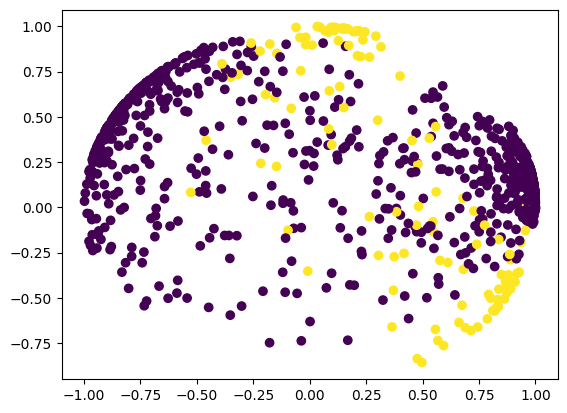

In [7]:
# Basic structure: let's do H2, but with a really high curvature

signature = [(-4, 2)]
pm = embedders.manifolds.ProductManifold(signature=signature)

X, y = embedders.gaussian_mixture.gaussian_mixture(pm=pm, seed=42, cov_scale_means=1.0, cov_scale_points=1.0)
X = X.detach().cpu().numpy()
y = y.detach().cpu().numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# hyperDT
hdt = HyperbolicDecisionTreeClassifier(max_depth=3, skip_hyperboloid_check=1)
hdt.fit(X_train, y_train)
print(hdt.score(X_test, y_test))

# sklearn
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(X_train, y_train)
print(dt.score(X_test, y_test))

# Also let's visualize the points
X_poincare = embedders.visualization.hyperboloid_to_poincare(X)
plt.scatter(X_poincare[:, 0], X_poincare[:, 1], c=y)

In [23]:
%%prun

import embedders
from tqdm.notebook import tqdm

# Filter UserWarning for singular matrix in gaussian mixture method
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

results = []

CURVATURES = [-4, -2, -0.5, -0.25, 0, 0.25, 0.5, 1, 2, 4]
DIM = 2
N_SAMPLES = 50
N_POINTS = 100
N_CLASSES = 10

with torch.no_grad():
    my_tqdm = tqdm(total=len(CURVATURES) * N_SAMPLES)
    for i, K in enumerate(CURVATURES):
        for seed in range(N_SAMPLES):
            # Ensure unique seed per trial
            seed = seed + N_SAMPLES * i
            pm = embedders.manifolds.ProductManifold(signature=[(K, DIM)], device=sample_device)

            # Get X, y
            X, y = embedders.gaussian_mixture.gaussian_mixture(
                pm=pm, 
                seed=seed, 
                num_points=N_POINTS, 
                num_classes=N_CLASSES, 
                cov_scale_means=1.0 / DIM, 
                cov_scale_points=1.0 / DIM
            )
            X = X.to(device)
            y = y.to(device)
            
            # Benchmarks are now handled by the benchmark function
            # accs = embedders.benchmarks.benchmark(X, y, pm, classifiers=["sklearn_dt", "product_dt", "tangent_dt"])
            accs = embedders.benchmarks.benchmark(X, y, pm)
            accs["curvature"] = K
            accs["seed"] = seed
            results.append(accs)

            my_tqdm.update(1)

results = pd.DataFrame(results)

# # Save these results
# results.to_csv(
#     "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/curvature_benchmarks.csv", index=False
# )

  0%|          | 0/500 [00:00<?, ?it/s]

         69841927 function calls (68795858 primitive calls) in 45.940 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   397252    3.564    0.000    4.081    0.000 tree_new.py:13(_angular_greater)
    45177    2.197    0.000    2.488    0.000 tree_new.py:75(_get_split)
    57500    1.956    0.000    4.069    0.000 validation.py:1411(check_random_state)
    36000    1.737    0.000    1.737    0.000 {function SeedSequence.generate_state at 0x10a5829e0}
    45177    1.679    0.000    3.814    0.000 tree_new.py:210(_get_best_split)
    45177    1.656    0.000    3.587    0.000 tree_new.py:32(_get_info_gains)
     7700    1.566    0.000    1.566    0.000 {method 'to' of 'torch._C.TensorBase' objects}
   389752    1.105    0.000    6.289    0.000 tree_new.py:321(_left)
   106800    1.003    0.000    3.238    0.000 inspect.py:2274(_signature_from_function)
   332739    0.944    0.000    0.952    0.000 {method 'sum' of 'torch._C.Te

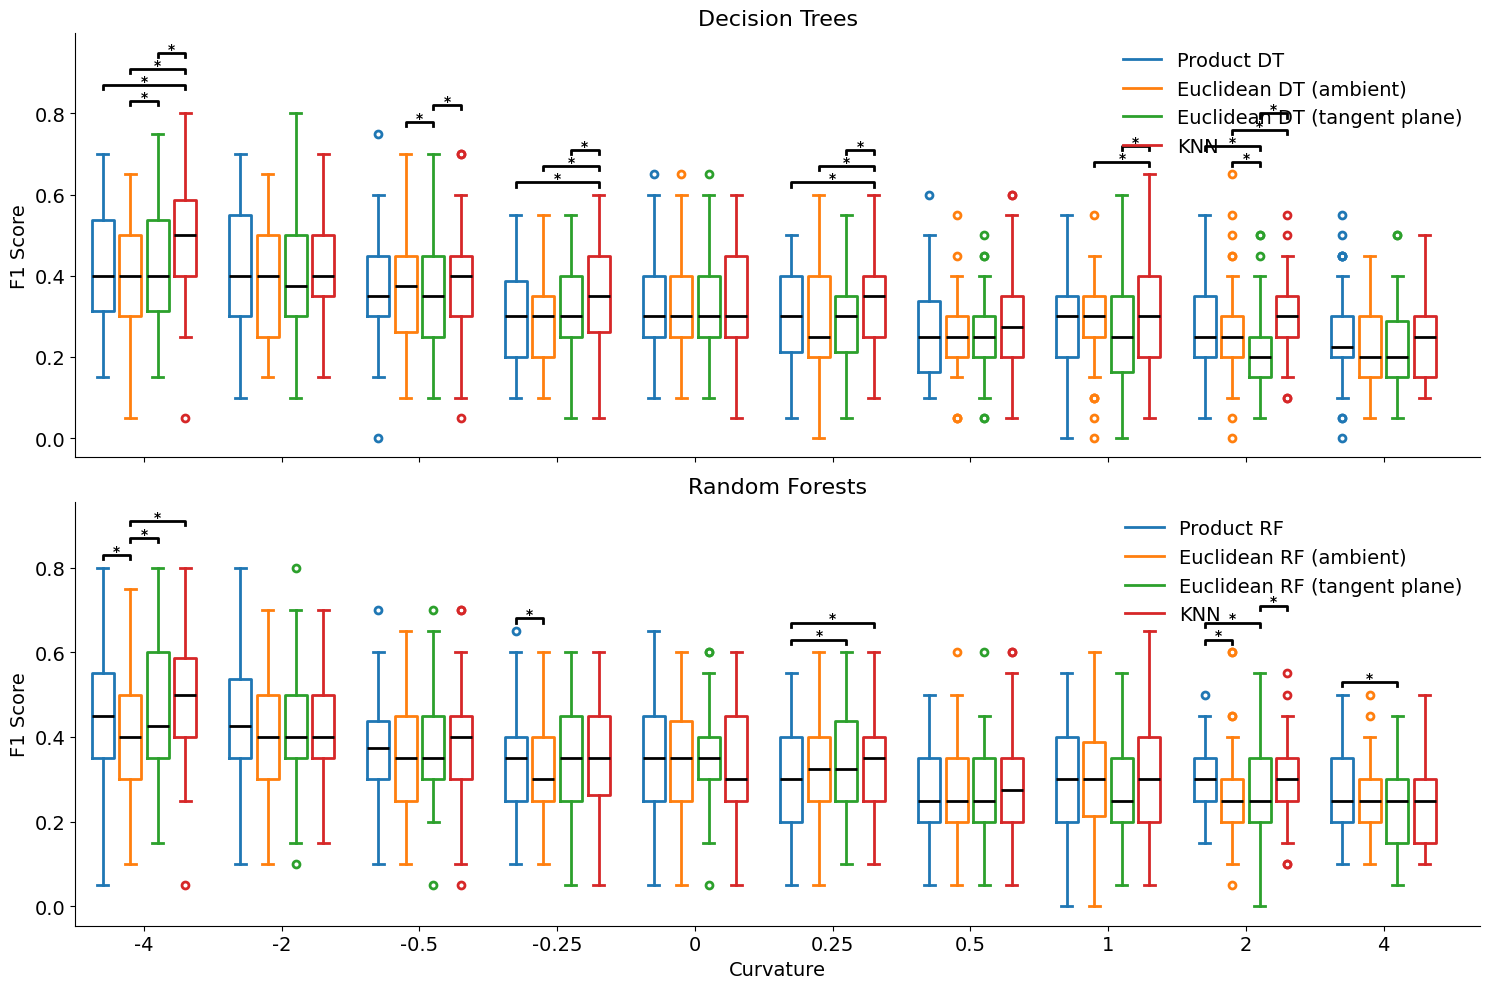

In [24]:
# Let's see the values: barplot with statistical significance annotations
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import wilcoxon

def test(x, y):
    # Check x and y are identical
    all_same = True
    for a, b in zip(x, y):
        if a != b:
            all_same = False
            break
    if all_same:
        return 1.0
    else:
        return wilcoxon(x, y).pvalue

# All the spec happens up here
models1 = ["product_dt", "sklearn_dt", "tangent_dt", "knn"]
model_names1 = ["Product DT", "Euclidean DT (ambient)", "Euclidean DT (tangent plane)", "KNN"]
models2 = ["product_rf", "sklearn_rf", "tangent_rf", "knn"]
model_names2 = ["Product RF", "Euclidean RF (ambient)", "Euclidean RF (tangent plane)", "KNN"]
colors = ["C0", "C1", "C2", "C3"]

# Initialize plot
fig, axs = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
x_vals = np.arange(len(CURVATURES)) * (len(models1) + 1)

for ax, models, model_names in zip(axs, [models1, models2], [model_names1, model_names2]):
    bps = []
    for i, (model, color) in enumerate(zip(models, colors)):
        # Initial boxplot
        bp = ax.boxplot(
            [results[results["curvature"] == K][model] for K in CURVATURES],
            positions=x_vals + i,
            widths=0.8,
            boxprops=dict(color=color, linewidth=2),
        )

        # Fix colors
        for element in ["boxes", "whiskers", "fliers", "means", "caps"]:
            plt.setp(bp[element], color=color, linewidth=2)
        plt.setp(bp["medians"], color="black", linewidth=2)
        plt.setp(bp["fliers"], marker="o", markersize=5, markeredgecolor=color, markeredgewidth=2)

        bps.append(bp)

    # Add p-value annotations. All start at x_vals, and end at x_vals + i
    heights = [0] * len(CURVATURES)  # How many annotations per curvature
    for i, j in [(0, 1), (1, 2), (0, 2), (0, 3), (1, 3), (2, 3)]:
        results_K = [results[results["curvature"] == K] for K in CURVATURES]
        p_vals = [test(res[models[i]], res[models[j]]) for res in results_K]

        for k, p_val in enumerate(p_vals):
            if p_val < 0.05:
                x1, x2 = x_vals[k] + i, x_vals[k] + j
                y = results[results["curvature"] == CURVATURES[k]][models].max().max() + 0.04 * (heights[k] + 1)
                ax.text(
                    s="*", x=(x1 + x2) / 2, y=y, ha="center", va="center", color="black", fontdict={"weight": "bold"}
                )
                ax.plot([x1, x1, x2, x2], [y - 0.02, y - 0.01, y - 0.01, y - 0.02], lw=2, color="black")
                heights[k] += 1

    # Fix y-lim and remove top/right spines; make background transparent
    ax.patch.set_alpha(0)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

    # Set x-ticks
    ax.set_ylabel("F1 Score", fontsize=14)
    ax.set_xticks(x_vals + 1.5, CURVATURES, fontsize=14)
    ax.legend([bp["boxes"][0] for bp in bps], model_names, loc="upper right", fontsize=14, frameon=False)
    ax.tick_params(axis="y", labelsize=14)

axs[0].set_title("Decision Trees", fontsize=16)
axs[1].set_title("Random Forests", fontsize=16)
axs[1].set_xlabel("Curvature", fontsize=14)

plt.xlim(-1, len(CURVATURES) * (len(models1) + 1))

# Transparent
plt.tight_layout()
plt.show()

In [35]:
embedders.manifolds.ProductManifold(signature=[(0, 3)])

# HyperDT benchmark - by signature

In [ ]:
SIGNATURES = [
    [(-1, 10)],
    [(0, 10)],
    [(1, 10)],
    [(-1, 5), (-1, 5)],
    [(1, 5), (1, 5)],
    [(-1, 5), (1, 5)],
    [(-1, 2), (-1, 2), (-1, 2), (-1, 2), (-1, 2)],
    [(1, 2), (1, 2), (1, 2), (1, 2), (1, 2)],
    [(-1, 2), (-1, 2), (0, 2), (1, 2), (1, 2)],
]

SIGNATURES_STR = [
    "H(-1, 10)",
    "E(0, 10)",
    "S(1, 10)",
    "H(-1, 5)^2",
    "S(1, 5)^2",
    "H(-1, 5) x \n S(1, 5)",
    "H(-1, 2)^5",
    "S(1, 2)^5",
    "H(-1, 2)^2 x \nE(0, 2) x \n S(1, 2)^2",
]

In [ ]:
device = "cpu"

In [ ]:
from tqdm.notebook import tqdm

import pandas as pd
import embedders

# Suppress warnings
import warnings

warnings.filterwarnings("ignore")

results2 = []

N_POINTS = 1_000
N_TRIALS = 50
N_CLASSES = 4
COV_SCALE_MEANS = 1.0
COV_SCALE_POINTS = 0.3

my_tqdm = tqdm(total=len(SIGNATURES) * N_TRIALS)
for i, signature in enumerate(SIGNATURES):
    for seed in range(N_TRIALS):
        # Ensure unique seed per trial
        seed = seed + N_TRIALS * i
        pm = embedders.manifolds.ProductManifold(signature=signature, device=device)

        # Get X, y
        X, y = embedders.gaussian_mixture.gaussian_mixture(
            pm=pm,
            seed=seed,
            num_points=N_POINTS,
            num_classes=N_CLASSES,
            cov_scale_means=COV_SCALE_MEANS / pm.dim,
            cov_scale_points=COV_SCALE_POINTS / pm.dim,
        )

        accs = embedders.benchmarks.benchmark(
            X,
            y,
            pm,
            device=device,
            classifiers=[
                "sklearn_dt",
                "tangent_dt",
                "product_dt",
                "product_dt_legacy",
                "sklearn_rf",
                "product_rf",
                "tangent_rf",
                "product_rf_legacy",
            ],
            score="accuracy",
        )
        accs["signature"] = SIGNATURES_STR[i]
        accs["seed"] = seed
        results2.append(accs)

        my_tqdm.update(1)

results2 = pd.DataFrame(results2)

results2.to_csv(
    "/teamspace/studios/this_studio/embedders/data/gaussian_mixture_benchmarks/signature_benchmarks.csv", index=False
)

  0%|          | 0/450 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:44<00:00,  2.22it/s]


KeyboardInterrupt: 

In [ ]:
# Turn table into 95% confidence intervals with p-values
import numpy as np

# from scipy.stats import ttest_rel
from scipy.stats import wilcoxon

start_str = """
\\begin{tabular}{cccccccc}
    \\toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
    \\hline
"""

SIGNATURES_LATEX = [
    "\\H{10}",
    "\\E{10}",
    "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

suffix = ""


print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    for model in ["product_dt", "sklearn_dt", "tangent_dt", "product_rf", "sklearn_rf", "tangent_rf"]:
        # for model in [f"product_dt{suffix}", "sklearn_dt", "tangent_dt"]:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        pre, post = model.split("_")[0], model.split("_")[1]
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        # if mean > _p.mean() and ttest_rel(r[model], _p).pvalue < 0.05:
        if mean > _p.mean() and wilcoxon(r[model], _p).pvalue < 0.05:
            asts.append("*")
        # if mean > _e.mean() and ttest_rel(r[model], _e).pvalue < 0.05:
        if mean > _e.mean() and wilcoxon(r[model], _e).pvalue < 0.05:
            asts.append("\dagger")
        # if mean > _t.mean() and ttest_rel(r[model], _t).pvalue < 0.05:
        if mean > _t.mean() and wilcoxon(r[model], _t).pvalue < 0.05:
            asts.append("\ddagger")
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)


\begin{tabular}{cccccccc}
    \toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\
    \hline

	$\H{10}$	& $\mathbf{88.5 \pm 1.6^{\dagger\ddagger}}$	& $86.6 \pm 1.6$	& $87.5 \pm 1.7^{\dagger}$	& $\mathbf{91.9 \pm 1.2^{\dagger}}$	& $90.5 \pm 1.4$	& $91.6 \pm 1.3^{\dagger}$	\\
	$\E{10}$	& $\mathbf{69.5 \pm 2.2}$	& $\mathbf{69.5 \pm 2.2}$	& $\mathbf{69.5 \pm 2.2}$	& $76.9 \pm 1.8$	& $\mathbf{77.3 \pm 1.8}$	& $77.1 \pm 1.7$	\\
	$\S{10}$	& $\mathbf{52.1 \pm 2.3^{\ddagger}}$	& $50.1 \pm 2.6^{\ddagger}$	& $46.3 \pm 2.4$	& $\mathbf{56.7 \pm 2.3^{\dagger\ddagger}}$	& $54.2 \pm 2.2^{\ddagger}$	& $51.8 \pm 2.1$	\\
	$(\H{5})^2$	& $\mathbf{87.9 \pm 1.9}$	& $87.5 \pm 1.9$	& $87.5 \pm 2.0$	& $\mathbf{90.8 \pm 1.5}$	& $90.3 \pm 1.6$	& $90.5 \pm 1.4$	\\
	$(\S{5})^2$	& $71.9 \pm 2.4$	& $\mathbf{72.7 \pm 2.2}$	& $72.5 \pm 

In [ ]:
# Turn table into 95% confidence intervals with p-values
import numpy as np
from scipy.stats import ttest_rel

start_str = """
\\begin{tabular}{cccccccc}
    \\toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\\\
    \\hline
"""

SIGNATURES_LATEX = [
    "\\H{10}",
    "\\E{10}",
    "\\S{10}",
    "(\\H{5})^2",
    "(\\S{5})^2",
    "\\H{5} \\times \\S{5}",
    "(\\H{2})^5",
    "(\\S{2})^5",
    "(\\H{2})^2 \\times \\E{2} \\times \\S{2}",
]

suffix = ""


print(start_str)
for signature, sigstr in zip(SIGNATURES_STR, SIGNATURES_LATEX):
    r = results2[results2["signature"] == signature]
    print(f"\t${sigstr}$", end="\t")
    for model in ["product_dt_legacy", "sklearn_dt", "tangent_dt", "product_rf_legacy", "sklearn_rf", "tangent_rf"]:
        # for model in [f"product_dt{suffix}", "sklearn_dt", "tangent_dt"]:
        mean = r[model].mean()
        std = r[model].std()
        n = r[model].shape[0]
        ci = 1.96 * std / np.sqrt(n)
        pre, post = model.split("_")[0], model.split("_")[1]
        asts = []
        _p, _e, _t = r[f"product_{post}"], r[f"sklearn_{post}"], r[f"tangent_{post}"]
        if mean > _p.mean() and ttest_rel(r[model], _p).pvalue < 0.05:
            asts.append("*")
        if mean > _e.mean() and ttest_rel(r[model], _e).pvalue < 0.05:
            asts.append("\dagger")
        if mean > _t.mean() and ttest_rel(r[model], _t).pvalue < 0.05:
            asts.append("\ddagger")
        if asts:
            asts = "^{" + "".join(asts) + "}"
        else:
            asts = ""
        if np.round(mean, 3) == max([np.round(x.mean(), 3) for x in [_p, _e, _t]]):
            print("& $\mathbf{" + f"{mean*100:.1f} \pm {ci*100:.1f}{asts}" + "}$", end="\t")
        else:
            print(f"& ${mean*100:.1f} \pm {ci*100:.1f}{asts}$", end="\t")
    print("\\\\")
end_str = """
    \\bottomrule
\\end{tabular}
"""
print(end_str)


\begin{tabular}{cccccccc}
    \toprule
                & Product space & Euclidean     & Tangent plane & Product space & Euclidean     & Tangent plane\\
    Signature   & decision tree & decision tree & decision tree & random forest & random forest & random forest\\
    \hline

	$(\H{5})^2$	& $98.6 \pm 0.6$	& $98.4 \pm 0.5$	& $98.6 \pm 0.4$	& $98.8 \pm 0.6$	& $98.5 \pm 0.5$	& $\mathbf{99.5 \pm 0.3^{*\dagger}}$	\\
	$(\S{5})^2$	& $65.4 \pm 2.1^{\ddagger}$	& $\mathbf{72.9 \pm 2.6^{*\ddagger}}$	& $61.1 \pm 2.0$	& $68.7 \pm 1.9^{\ddagger}$	& $\mathbf{74.7 \pm 1.7^{*\ddagger}}$	& $66.4 \pm 1.6$	\\
	$\H{5} \times \S{5}$	& $\mathbf{97.2 \pm 0.8^{\dagger\ddagger}}$	& $94.5 \pm 1.1$	& $96.2 \pm 1.0^{\dagger}$	& $97.3 \pm 0.7^{\dagger\ddagger}$	& $94.5 \pm 1.1$	& $96.1 \pm 1.0^{\dagger}$	\\
	$(\H{2})^5$	& $94.1 \pm 1.2$	& $95.5 \pm 1.0$	& $96.0 \pm 1.0^{\dagger}$	& $94.8 \pm 1.0$	& $96.9 \pm 0.9$	& $\mathbf{97.6 \pm 0.7^{\dagger}}$	\\
	$(\S{2})^5$	& $83.2 \pm 1.9^{\ddagger}$	& $\mathbf{88.1 \pm 